In [1]:
import os
import sys
sys.path.append(os.getcwd())

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import mixture
import matplotlib.pyplot as plt
import time 


from lib.utils import *

### Reading Data

In [2]:
train_data, train_label, test_data, test_label =  prepare_mnist_dataset()
pca = PCA(0.8, whiten=True)
pca.fit(train_data)
train_data_pca = pca.transform(train_data)
test_data_pca = pca.transform(test_data)

************************ Loading mnist ************************
n_digits: 10
n_samples: 60000
************************ Finished mnist ************************


In [5]:
len(test_data)

10000

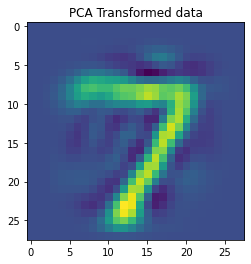

In [66]:
plt.title("PCA Transformed data")
plt.imshow(pca.inverse_transform(test_data_pca[0]).reshape(28,28))
plt.show()


Fitting for model: GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=100, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
12.506806135177612
Fitting for model: GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=400, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
56.73053812980652
Fitting for model: GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=700, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10,

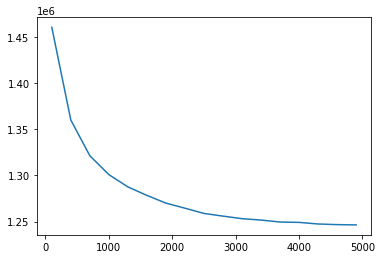

In [18]:

n_components = np.arange(100, 5000, 300)
models = [mixture.GaussianMixture(n, covariance_type='diag', random_state=0)
        for n in n_components]
aics = []
for model in models:
    print("Fitting for model:", model)
    t_s = time.time()
    fitted_model = model.fit(train_data_pca)
    aics.append(fitted_model.aic(train_data_pca) )
    dt = time.time() - t_s
    print(dt)
plt.plot(n_components, aics)

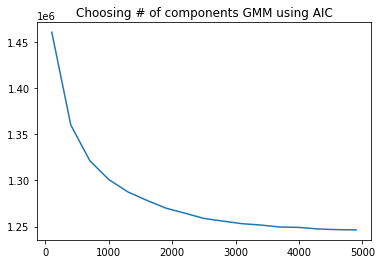

In [68]:
plt.title("Choosing # of components GMM using AIC")
plt.plot(n_components, aics)
plt.show()

In [71]:
n_comp = 40
cov_type = 'full'
print("Train:", train_data_pca.shape, "Test:", test_data_pca.shape, "Diag_type:", cov_type, "Num_comp", n_comp)
gmm = mixture.GaussianMixture(n_components=n_comp, covariance_type=cov_type)
gmm.fit(train_data_pca)


train_pred = gmm.predict(train_data_pca)
train_final_pred, label_dict = assign_majority(train_pred, train_label)
print("Train Acc:", np.mean(train_final_pred == train_label))

test_pred = gmm.predict(test_data_pca)
test_final_pred = pred_majority(test_pred, label_dict)
print("Test Acc:", np.mean(test_final_pred == test_label))

Train: (60000, 44) Test: (10000, 44) Diag_type: full Num_comp 40
Train Acc: 0.8475333333333334
Test Acc: 0.8517


In [93]:
from scipy.optimize import linear_sum_assignment
def bipartite_match(pred, gt, n_classes=None, presence=None):
    """Does maximum biprartite matching between `pred` and `gt`."""

    if n_classes is not None:
        n_gt_labels, n_pred_labels = n_classes, n_classes
    else:
        n_gt_labels = np.unique(gt).shape[0]
        n_pred_labels = np.unique(pred).shape[0]

    cost_matrix = np.zeros([n_gt_labels, n_pred_labels], dtype=np.int32)
    for label in range(n_gt_labels):
        label_idx = (gt == label)
        for new_label in range(n_pred_labels):
            errors = np.equal(pred[label_idx], new_label).astype(np.float32)
            if presence is not None:
                errors *= presence[label_idx]

            num_errors = errors.sum()
            cost_matrix[label, new_label] = -num_errors

    row_idx, col_idx = linear_sum_assignment(cost_matrix)
    num_correct = -cost_matrix[row_idx, col_idx].sum()
    acc = float(num_correct) / gt.shape[0]
    return acc

bipartite_match(train_pred, train_label)

0.2676

In [94]:
import os
import sys
sys.path.append(os.getcwd())

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from lib.kmeans_lib import *
from lib.utils import *

In [97]:
n_samples = train_data.shape[0]
n_digits = 10
t0 = time()

print("done in %0.3fs" % (time() - t0))
assigned_labels, train_final_pred = assign_labels_to_centroids_bipartite(km.labels_, train_label)
train_acc = np.sum(train_final_pred == train_label) / n_samples
print("train acc: %.3f" % train_acc)

predicted_label = km.predict(test_data)
test_final_pred = np.zeros_like(predicted_label)
for i in range(10):
    test_final_pred[predicted_label == i] = assigned_labels[i]

# _, test_final_pred = assign_labels_to_centroids(km.predict(test_data), test_label)
test_acc = np.sum(test_final_pred == test_label) / len(test_label)
print("test acc: %.3f" % test_acc)

done in 10.972s
train acc: 0.513
test acc: 0.517


In [126]:
def assign_majority(pred, label):
    unique_pred = np.unique(pred)
    final_pred = np.zeros(pred.shape)
    label_dict = {}

    for i in unique_pred:
        pred_cases = np.where(pred == i)
        case_labels = label[pred_cases[0]]
        counts, freq = np.unique(case_labels, return_counts=True)
        assigned_label = counts[np.argmax(freq)]
        label_dict[i] = assigned_label
    for i in unique_pred:
        final_pred[pred == i] = label_dict[i]
    return final_pred, label_dict
km = KMeans(init='k-means++', n_clusters=30, n_init=1).fit(train_data)
pred_labesl = km.labels_
final_pred, label_dict = assign_majority(pred_labesl, train_label)
np.sum(final_pred == train_label)/train_label.shape[0]

0.7528166666666667

In [7]:
def prepare_shapenet_dataset():
    print("************************ Loading shapnet ************************")
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    train_data, train_label = get_all_data_mnist(mnist_trainset) # train_data is 60000 x 28 x 28

    n_samples = train_data.shape[0]
    n_digits = len(np.unique(train_label))

    print("n_digits: %d" % n_digits)
    print("n_samples: %d" % n_samples)

    train_data = train_data.reshape(-1, 784) # flatten, 60000 x 784
    train_label = train_label.astype(int)

    test_data, test_label = get_all_data_mnist(mnist_testset)
    test_data = test_data.reshape(-1, 784)
    test_label = test_label.astype(int)
    print("************************ Finished mnist ************************")
    return train_data, train_label, test_data, test_label



In [1]:
import os
import sys
import pdb
import glob
sys.path.append(os.getcwd())

from PIL import Image
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.utils.data as data
import argparse
import time
import random
# import numpy.ma as ma
from lib.utils import *

input_size = 128


********************** Loading Shapenet Dataset **********************
Dataset Mode:  train
Dataset Length:  0
********************** Finished Shapenet Dataset **********************


In [3]:
def get_all_data_shapenet(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1200,  shuffle=True, num_workers=8)
    imgs = []
    targets = []

    for i, (data, target) in enumerate(loader):
        imgs.append(data.numpy().squeeze())
        targets.append(target.numpy().squeeze())
    imgs = np.concatenate(imgs)
    targets = np.concatenate(targets)
    return imgs.reshape(imgs.shape[0], -1), targets.astype(int)

def prepare_shapenet_dataset(shapenet_root):
    transforms_shapenet = transforms.Compose([transforms.Grayscale(), transforms.Resize(128), transforms.ToTensor()])
    train_dataset = ShapenetDataset("train", shapenet_root, transforms=transforms_shapenet)
    test_dataset = ShapenetDataset("test", shapenet_root, transforms=transforms_shapenet)

    train_imgs, train_labels = get_all_data_shapenet(train_dataset)
    test_imgs, test_labels = get_all_data_shapenet(test_dataset)
    return train_imgs, train_labels, test_imgs, test_labels

********************** Loading Shapenet Dataset **********************
Dataset Mode:  train
Dataset Length:  60000
********************** Finished Shapenet Dataset **********************
********************** Loading Shapenet Dataset **********************
Dataset Mode:  test
Dataset Length:  10000
********************** Finished Shapenet Dataset **********************


In [8]:
from sklearn import mixture
from sklearn.decomposition import PCA
def train_gmm(train_data, test_data, train_label, test_label, pca_percent = 0.8, cov_type = 'full', n_comp = 80):
    pca = PCA(pca_percent, whiten=True)
    pca = pca.fit(train_data)
    train_data_pca = pca.transform(train_data)
    test_data_pca = pca.transform(test_data)

    print("Train:", train_data_pca.shape, "Test:", test_data_pca.shape, "Diag_type:", cov_type, "Num_comp", n_comp)
    gmm = mixture.GaussianMixture(n_components=n_comp, covariance_type=cov_type)
    gmm.fit(train_data_pca)

    train_pred = gmm.predict(train_data_pca)
    train_final_pred, label_dict = assign_majority(train_pred, train_label)
    print("Train Acc:", np.mean(train_final_pred == train_label))

    test_pred = gmm.predict(test_data_pca)
    test_final_pred = pred_majority(test_pred, label_dict)
    print("Test Acc:", np.mean(test_final_pred == test_label))
    
    return train_data_pca, test_data_pca, gmm

In [ ]:
train_data, train_label, test_data, test_label = prepare_shapenet_dataset("/hdd/zen/data/Reallite/Rendering/chair_cls1")
results = []
for percent in np.linspace(0.4, 1, 5):
    for n_comp in range(10, 150, 20):
        print(percent, n_comp)
        res = train_gmm(train_data, test_data, train_label, test_label, n_comp = n_comp, pca_percent = percent)
        results.append((res,percent, n_comp))
        print("---------")
pk.dump(results, open("shapenet_res.pkl", "wb"))

In [83]:
train_data, train_label, test_data, test_label = prepare_shapenet_dataset("/hdd/zen/data/Reallite/Rendering/chair_cls1")
# results = pk.load(open("shapenet_res.pkl", "rb"))
# results = pk.load(open("gmm_res.pk", "rb"))
# results = pk.load(open("mnist_res.pkl", "rb"))
num_results = []
for res, percent, n_comp in results:
    train_data_pca, test_data_pca, gmm = res
    train_pred = gmm.predict(train_data_pca)
    train_final_pred, label_dict = assign_majority(train_pred, train_label)
    train_acc = np.mean(train_final_pred == train_label)
    print("Train Acc:", train_acc)

    test_pred = gmm.predict(test_data_pca)
    test_final_pred = pred_majority(test_pred, label_dict)
    test_acc = np.mean(test_final_pred == test_label)
    print("Test Acc:", test_acc)
    num_results.append([percent, n_comp, test_acc, train_acc])
    print("---------------")
    break

********************** Loading Shapenet Dataset **********************
Dataset Mode:  train
Dataset Length:  60000
********************** Finished Shapenet Dataset **********************
********************** Loading Shapenet Dataset **********************
Dataset Mode:  test
Dataset Length:  10000
********************** Finished Shapenet Dataset **********************
Train Acc: 0.10663333333333333
Test Acc: 0.1013
---------------


In [84]:
train_gmm(train_data, test_data, train_label, test_label, n_comp = 130, pca_percent = 0.4)

Train: (60000, 10) Test: (10000, 10) Diag_type: full Num_comp 130
Train Acc: 0.7467833333333334
Test Acc: 0.7456


(array([[-0.0599856 ,  1.1549321 ,  1.2061636 , ..., -0.6316522 ,
          0.04324555, -0.6490124 ],
        [ 0.594026  , -0.04988861, -0.30825853, ..., -0.36665875,
          0.43171415, -0.47991443],
        [-0.69227725, -0.14596406,  1.9005666 , ...,  0.09382654,
         -0.41947186, -1.0258007 ],
        ...,
        [ 2.28007   ,  2.5673516 , -1.7221609 , ...,  0.89695615,
         -1.9330819 ,  0.97890854],
        [-0.41678807,  0.18737888,  0.74149245, ...,  0.39466113,
         -1.0159398 ,  1.4918615 ],
        [-0.5582272 ,  0.5599438 ,  0.25967693, ...,  1.2795209 ,
          0.01965784,  0.9412623 ]], dtype=float32),
 array([[ 1.2943026 ,  0.45118225,  1.2212111 , ...,  1.3838397 ,
          0.5397786 ,  0.13172771],
        [-0.5597056 ,  0.47293052, -0.89658594, ...,  0.5413628 ,
          0.9440707 ,  0.04769094],
        [-0.47140595, -0.99291825, -1.4354997 , ..., -0.49724284,
          1.1882927 ,  1.3497306 ],
        ...,
        [-1.3070908 ,  0.24634778,  0.0

In [ ]:
import matplotlib.pyplot as plt
num_results = np.array(num_results)
print(num_results)
plt.plot(num_results[:,3])

### MNIST

In [49]:
train_data, train_label, test_data, test_label = prepare_mnist_dataset()
results = []
for percent in np.linspace(0.4, 1, 5):
    for n_comp in range(10, 150, 20):
        print(percent, n_comp)
        res = train_gmm(train_data, test_data, train_label, test_label, n_comp = n_comp, pca_percent = percent)
        results.append((res,percent, n_comp))
        print("---------")


************************ Loading mnist ************************
n_digits: 10
n_samples: 60000
************************ Finished mnist ************************
0.4 10
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 10
Train Acc: 0.6373833333333333
Test Acc: 0.6393
---------
0.4 30
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 30
Train Acc: 0.7219166666666667
Test Acc: 0.7211
---------
0.4 50
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 50
Train Acc: 0.7712
Test Acc: 0.7764
---------
0.4 70
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 70
Train Acc: 0.7965833333333333
Test Acc: 0.7961
---------
0.4 90
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 90
Train Acc: 0.80205
Test Acc: 0.8039
---------
0.4 110
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 110
Train Acc: 0.8091
Test Acc: 0.8084
---------
0.4 130
Train: (60000, 7) Test: (10000, 7) Diag_type: full Num_comp 130
Train Acc: 0.81235
Test Acc: 0.8098
----

/root/anaconda3/envs/actmix/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Train Acc: 0.787
Test Acc: 0.7943
---------
0.85 50
Train: (60000, 59) Test: (10000, 59) Diag_type: full Num_comp 50


/root/anaconda3/envs/actmix/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Train Acc: 0.8439166666666666
Test Acc: 0.8471
---------
0.85 70
Train: (60000, 59) Test: (10000, 59) Diag_type: full Num_comp 70
Train Acc: 0.8539
Test Acc: 0.8498
---------
0.85 90
Train: (60000, 59) Test: (10000, 59) Diag_type: full Num_comp 90


/root/anaconda3/envs/actmix/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Train Acc: 0.8762833333333333
Test Acc: 0.8703
---------
0.85 110
Train: (60000, 59) Test: (10000, 59) Diag_type: full Num_comp 110
Train Acc: 0.8983833333333333
Test Acc: 0.8918
---------
0.85 130
Train: (60000, 59) Test: (10000, 59) Diag_type: full Num_comp 130
Train Acc: 0.9012666666666667
Test Acc: 0.8968
---------
1.0 10


ValueError: n_components=1.0 must be of type int when greater than or equal to 1, was of type=<class 'numpy.float64'>

In [81]:
# pk.dump(results, open("mnist_res.pkl", "wb"))
# results = pk.load(open("mnist_res.pkl", "rb"))
results = pk.load(open("shapenet_res.pkl", "rb"))
train_data, train_label, test_data, test_label = prepare_mnist_dataset()
num_results = []
for res, percent, n_comp in results:
    train_data_pca, test_data_pca, gmm = res
    train_pred = gmm.predict(train_data_pca)
    train_final_pred, label_dict = assign_majority(train_pred, train_label)
    train_acc = np.mean(train_final_pred == train_label)
    print("Train Acc:", train_acc)

    test_pred = gmm.predict(test_data_pca)
    test_final_pred = pred_majority(test_pred, label_dict)
    test_acc = np.mean(test_final_pred == test_label)
    print("Test Acc:", test_acc)
    num_results.append([percent, n_comp, test_acc, train_acc])
    print("---------------")
    break

************************ Loading mnist ************************
n_digits: 10
n_samples: 60000
************************ Finished mnist ************************
Train Acc: 0.11241666666666666
Test Acc: 0.1128
---------------


[[  0.4         10.           0.6393       0.63738333]
 [  0.4         30.           0.7211       0.72191667]
 [  0.4         50.           0.7764       0.7712    ]
 [  0.4         70.           0.7961       0.79658333]
 [  0.4         90.           0.8039       0.80205   ]
 [  0.4        110.           0.8084       0.8091    ]
 [  0.4        130.           0.8098       0.81235   ]
 [  0.55        10.           0.6439       0.63668333]
 [  0.55        30.           0.8011       0.79965   ]
 [  0.55        50.           0.8609       0.86395   ]
 [  0.55        70.           0.8955       0.89998333]
 [  0.55        90.           0.8977       0.89998333]
 [  0.55       110.           0.8976       0.90018333]
 [  0.55       130.           0.907        0.91256667]
 [  0.7         10.           0.6726       0.67041667]
 [  0.7         30.           0.8205       0.81363333]
 [  0.7         50.           0.8965       0.89228333]
 [  0.7         70.           0.9022       0.90345   ]
 [  0.7   

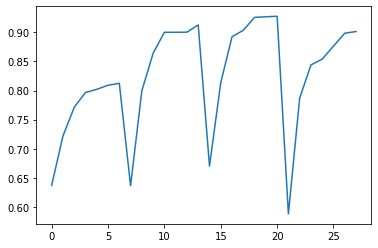

In [52]:
import matplotlib.pyplot as plt
num_results = np.array(num_results)
print(num_results)
plt.plot(num_results[:,3])

In [60]:
np.max(num_results[:,3])

0.9275